# Wavelet Power Spectrum

In [1]:
from bokeh.plotting import figure as figbok
from bokeh.io import output_notebook
from bokeh.io import show as showbok
import numpy as np
output_notebook()
%pylab inline

Loading BokehJS ...

Populating the interactive namespace from numpy and matplotlib


## Gaussian Random Field

Produce a fractional Brownian motion (fBm)

Mean =  6.938893903907228e-18
Sigma =  1.0


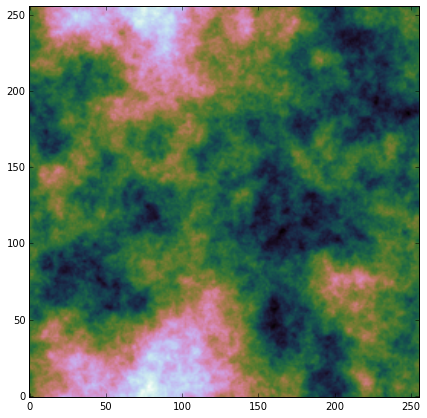

In [2]:
from noisegen import fbm2d

fbm = fbm2d(-3.1,256,256)

#Add non-Gaussianities
#fbm = np.exp(fbm)

figure(figsize=(7,7))
imshow(fbm,origin='below',cmap='cubehelix')
print 'Mean = ', np.mean(fbm)
print 'Sigma = ', np.std(fbm)

- A shallower slope ($\alpha\sim-2.0$ to $-2.7$) has a Gaussian distribution.
- A steeper slope ($\alpha \sim -2.7$ to $-3.2$) shows a more complex distribution.
- It is easier to separate coherent structures on steeper slopes.

Show histogram

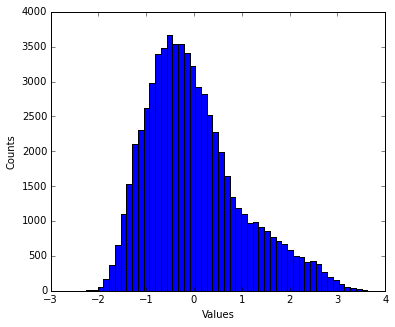

In [3]:
figure(figsize=(6,5))
histo, edges = np.histogram(fbm,bins=50)
plt.bar(edges[:-1], histo, width=np.diff(edges), align="edge")
plt.xlabel('Values')
plt.ylabel('Counts')

Calculate the power spectra

In [4]:
from powspec import powspec
from wavan import fan_trans

#Fourier power spectrum
tab_k, spec_k = powspec(fbm, reso=1)

#Fit
coef = np.polyfit(np.log(tab_k),np.log(spec_k),deg=1)

yfit = np.exp(coef[1])*tab_k**coef[0]

print "Power law = ", coef[0]

#Plot Fourier power spectrum
f = figbok( x_axis_label="P[k]", x_axis_type="log", \
           y_axis_label="Wavenumber k", y_axis_type="log")
f.line(tab_k, spec_k, legend='Fourier')
f.line(tab_k, yfit, line_dash='dashed',color='red', legend='Fit')

#Wavelet power spectrum
wt, wav_k, S1a = fan_trans(fbm, reso=1, q=0)

f.diamond(wav_k, S1a[:], legend='Wavelet',color='black',line_width=5)
#f.triangle(wav_k, S1a[1,:], legend='Coherent',color='blue',line_width=5)
#f.square(wav_k, S1a[2,:], legend='Gaussian',color='red',line_width=5)

showbok(f)

Power law =  -3.0745657845216123


Same graph with matplotlib:

Power law =  -3.0745657845216123


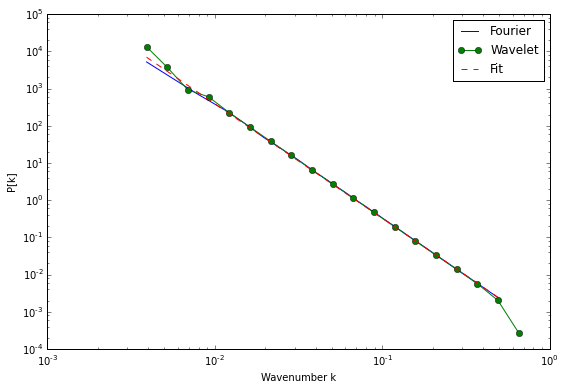

In [5]:
#Fourier power spectrum
tab_k, spec_k = powspec(fbm, reso=1)

#Fit
coef = np.polyfit(np.log(tab_k),np.log(spec_k),deg=1)

yfit = np.exp(coef[1])*tab_k**coef[0]

print "Power law = ", coef[0]

#Plot Fourier power spectrum
figure(figsize=(9,6))
plot(tab_k, spec_k,label='Fourier')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Wavenumber k")
plt.ylabel("P[k]")

#Wavelet power spectrum
wt, wav_k, S1a = fan_trans(fbm, reso=1, q=0)
plot(wav_k, S1a,marker='o',label='Wavelet')

#Fit
plot(tab_k,yfit,linestyle='--',label='Fit')

plt.legend()

## Gaussian Random Field with Filaments

The fBm has a pwer off -3.2 and filaments fluctuations have a power law of -2.35

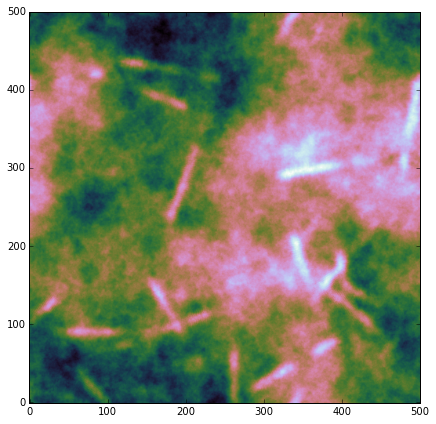

In [6]:
from astropy.io import fits

HDU = fits.open('/Users/jfrob/postdoc/fil2star/test/model3.fits')
model = HDU[0].data

figure(figsize=(7,7))
imshow(model,origin='below',cmap='cubehelix')

Show histogram

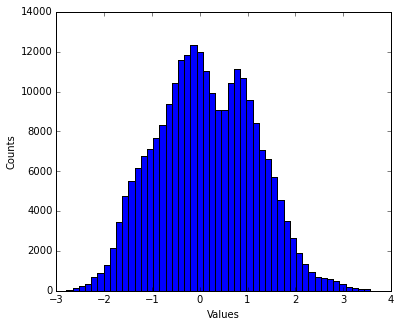

In [7]:
figure(figsize=(6,5))
histo, edges = np.histogram(model,bins=50)
plt.bar(edges[:-1], histo, width=np.diff(edges), align="edge")
plt.xlabel('Values')
plt.ylabel('Counts')

In [8]:
#Fourier power spectrum
tab_k, spec_k = powspec(model, reso=1)

#Plot Fourier power spectrum
f = figbok( x_axis_label="Wavenumber k", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log")
f.line(tab_k, spec_k, legend='Fourier')

#Set a list of q
q = [2.0]*21

#Wavelet power spectrum
wt, wav_k, S1a = fan_trans(model, reso=1, q=q)

#Fit
coef = np.polyfit(np.log(wav_k),np.log(S1a[2,:]),deg=1)
yfit = np.exp(coef[1])*tab_k**coef[0]

print "Power law = ", coef[0]

#f.diamond(wav_k, S1a[0,:], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_k, S1a[1,:], legend='Coherent',color='blue',line_width=5)
f.square(wav_k, S1a[2,:], legend='Gaussian',color='red',line_width=5)
f.line(tab_k, yfit, line_dash='dashed',color='red', legend='Fit')

#Fourier power spectrum of filaments alone
HDUf = fits.open('/Users/jfrob/postdoc/fil2star/test/filaments3.fits')
filaments = HDUf[0].data
tab_k, spec_kf = powspec(filaments, reso=1)

f.line(tab_k, spec_kf, legend='Fourier',color='blue')

showbok(f)

Power law =  -3.2937081831131367


Reconstruct Segmented Structures

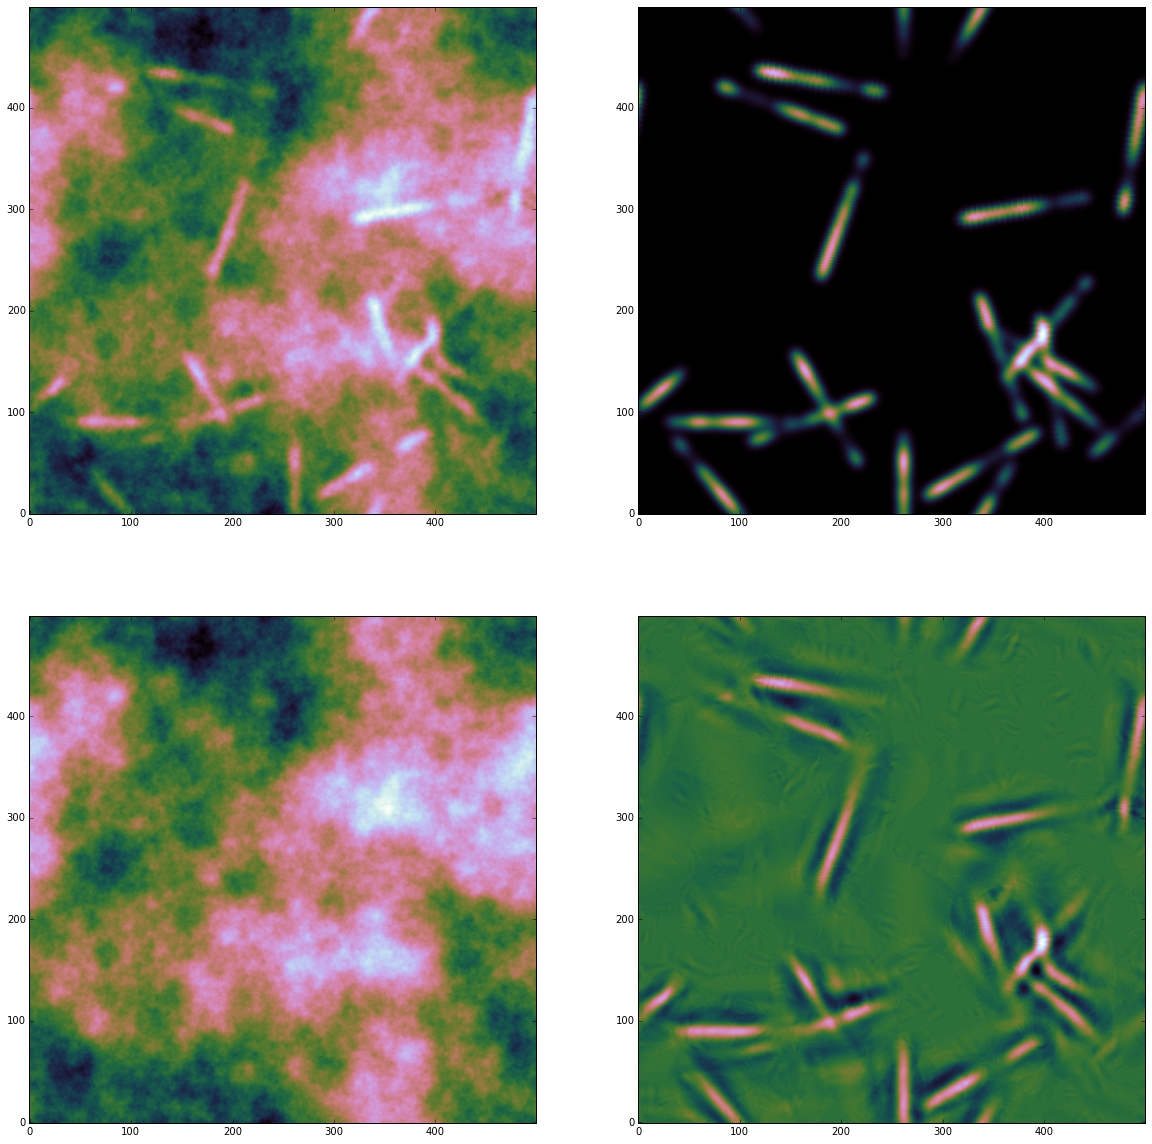

In [9]:
#from halo_inverse import halo_inverse

#Reconstruction
M = wav_k.shape[0]
#coherent = halo_inverse(wt[M:2*M,:,:],wav_k)
#Gaussian = halo_inverse(wt[2*M:3*M,:,:],wav_k)

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)

plt.figure(figsize=(20,20))

plt.subplot(221)
plt.imshow(model,origin='below',cmap='cubehelix')
plt.subplot(222)
plt.imshow(filaments,origin='below',cmap='cubehelix')
plt.subplot(223)
plt.imshow(Gaussian.real,origin='below',cmap='cubehelix')
plt.subplot(224)
plt.imshow(coherent.real,origin='below',cmap='cubehelix')

A $q$ parameter $\gtrsim2$ gives better results at smaller scales. On the other hand, $q \lesssim 2$ gives better results at larger scales. Consequently, $q$ should probably be set as a list in the fan_trans function instead to have a single value for every spatial scales as in Robitaille et al. 2014.

In [10]:
#Fourier power spectrum
tab_k, spec_k = powspec(model, reso=1)

#Plot Fourier power spectrum
f = figbok( x_axis_label="Wavenumber k", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log")
f.line(tab_k, spec_k, legend='Fourier')

#Set a list of q
q = [2.5,2.5,2.5,1.8,1.8,1.8,1.9,1.9,1.9,1.9,1.9,1.9,2.1,2.6,2.7,2.7\
     ,2.7,2.7,2.8,2.8,2.8]
#q = [2.5]*21

#Wavelet power spectrum
wt, wav_k, S1a = fan_trans(model, reso=1, q=q)

#Fit
coef = np.polyfit(np.log(wav_k),np.log(S1a[2,:]),deg=1)
yfit = np.exp(coef[1])*tab_k**coef[0]

print "Power law = ", coef[0]

#f.diamond(wav_k, S1a[0,:], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_k, S1a[1,:], legend='Coherent',color='blue',line_width=5)
f.square(wav_k, S1a[2,:], legend='Gaussian',color='red',line_width=5)
f.line(tab_k, yfit, line_dash='dashed',color='red', legend='Fit')

#Fourier power spectrum of filaments alone
HDUf = fits.open('/Users/jfrob/postdoc/fil2star/test/filaments3.fits')
filaments = HDUf[0].data
tab_k, spec_kf = powspec(filaments, reso=1)

f.line(tab_k, spec_kf, legend='Fourier',color='blue')

showbok(f)

Power law =  -3.243872993072971


Reconstruct Segmented Structures

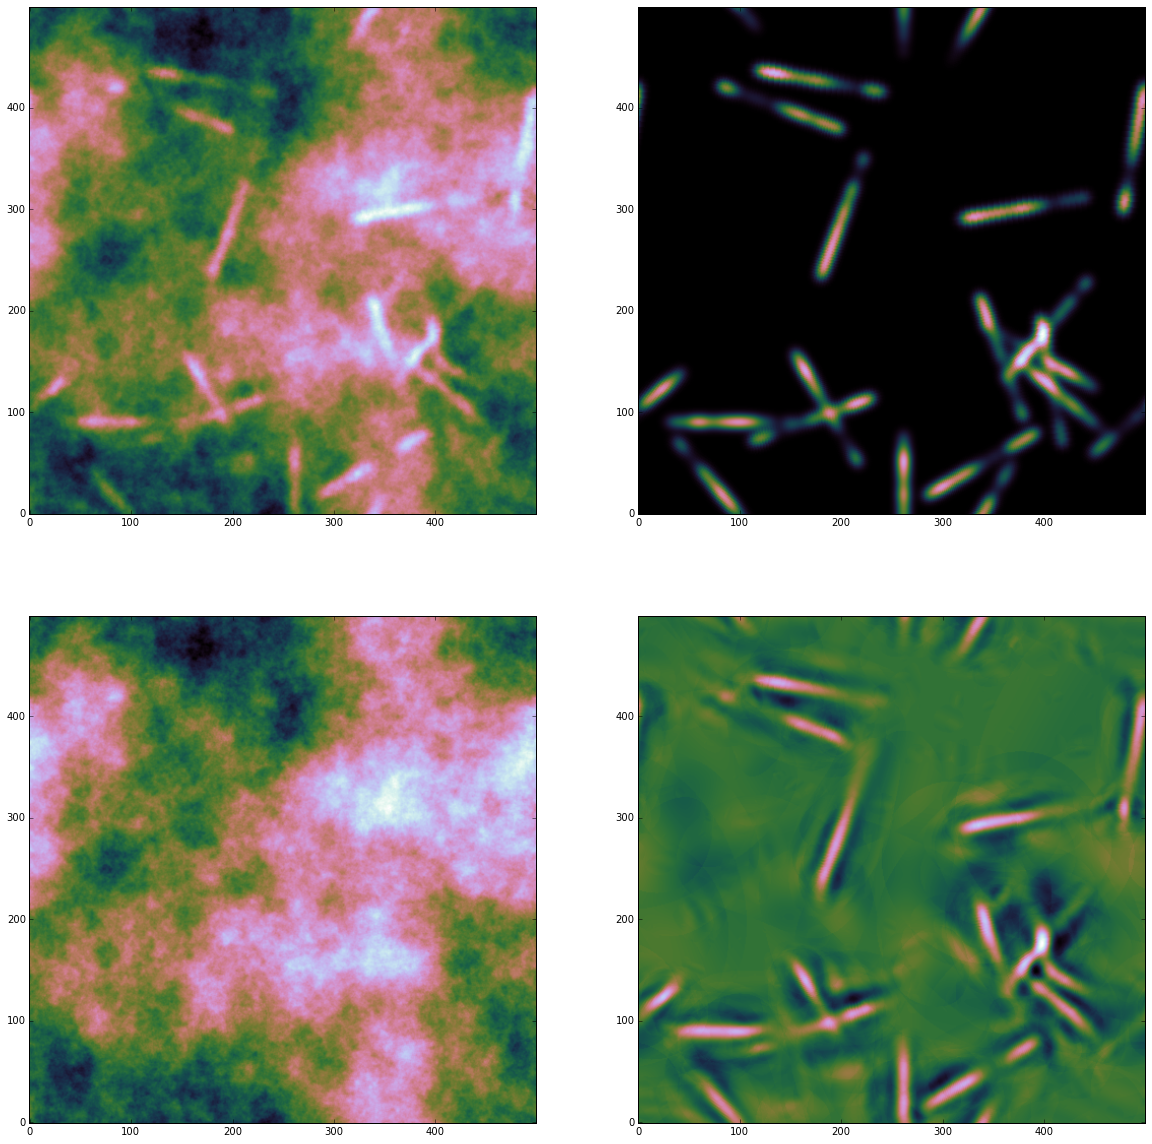

In [11]:
#from halo_inverse import halo_inverse

#Reconstruction
M = wav_k.shape[0]
#coherent = halo_inverse(wt[M:2*M,:,:],wav_k)
#Gaussian = halo_inverse(wt[2*M:3*M,:,:],wav_k)

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)

plt.figure(figsize=(20,20))

plt.subplot(221)
plt.imshow(model,origin='below',cmap='cubehelix')
plt.subplot(222)
plt.imshow(filaments,origin='below',cmap='cubehelix')
plt.subplot(223)
plt.imshow(Gaussian.real,origin='below',cmap='cubehelix')
plt.subplot(224)
plt.imshow(coherent.real,origin='below',cmap='cubehelix')

There are less spurious features at smaller scales.

Show histograms of Wavelet coefficients

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


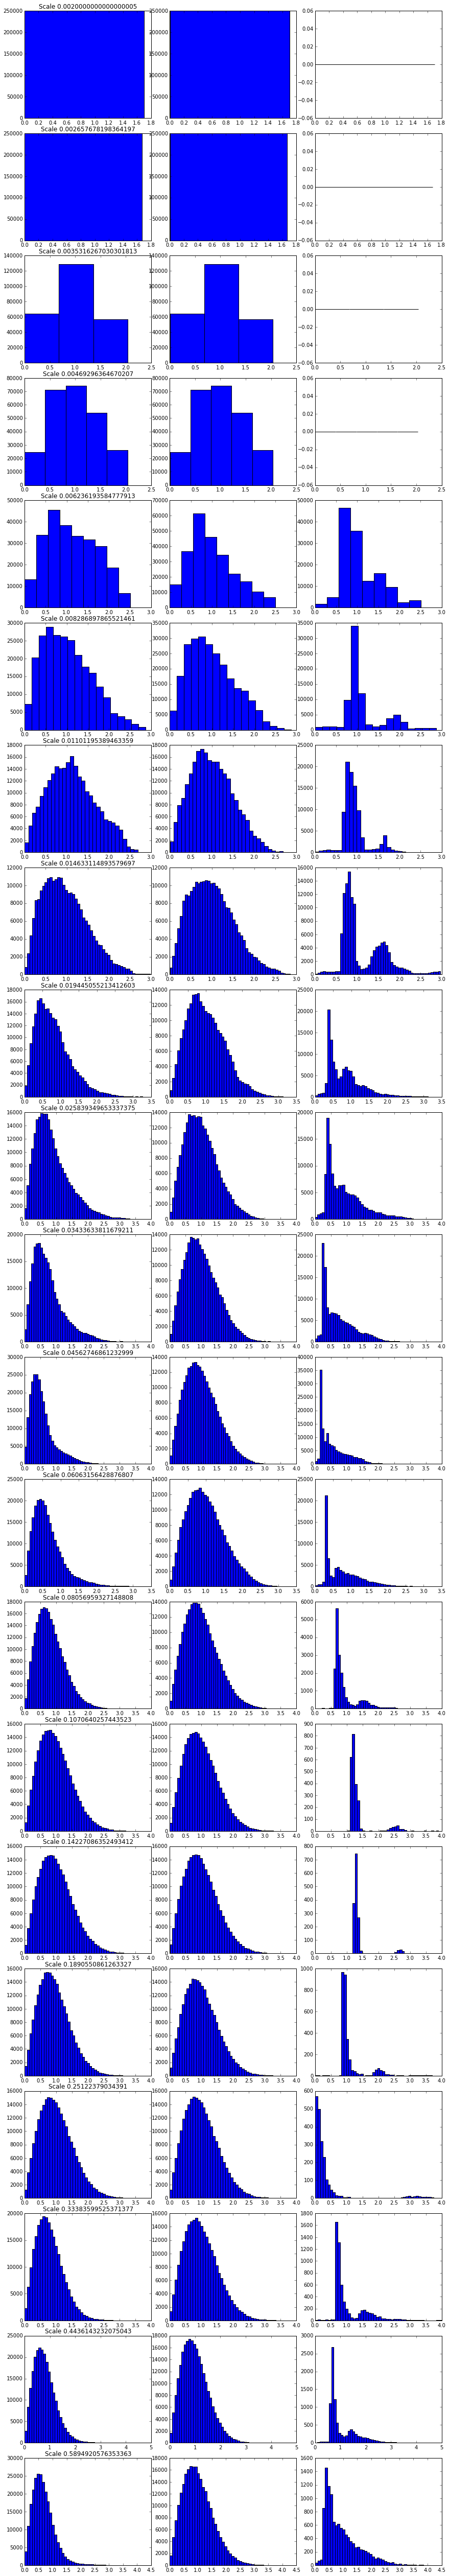

In [31]:
fig, axs = plt.subplots(21,3,figsize=(12,70))

axs = axs.ravel()
fig.tight_layout()

for i in range(M):

    wo = abs(wt[i,:,:])/np.mean(abs(wt[i,:,:]))
    wg = abs(wt[2*M+i,:,:])/np.mean(abs(wt[2*M+i,:,:]))
    wc = abs(wt[M+i,:,:])/np.mean(abs(wt[M+i,:,:]))
    
    #Number of independent points
    npix = np.int((model.shape[0] * wav_k[i])**2.)
    if npix < 50: nbins=npix
    else: nbins=50

    histo, edges = np.histogram(wo,bins=nbins)
    histo_c, edges = np.histogram(wc[wc > 0.],bins=nbins)
    histo_g, edges = np.histogram(wg,bins=nbins)
    
    axs[i*3].bar(edges[:-1], histo, width=np.diff(edges), align="edge")
    axs[i*3].set_title('Scale '+np.str(wav_k[i]))
    
    axs[i*3+1].bar(edges[:-1], histo_g, width=np.diff(edges), align="edge")
    
    axs[i*3+2].bar(edges[:-1], histo_c, width=np.diff(edges), align="edge")

Left: Original image, center: Gaussian part, right: Non-gaussian part

Large skewness noticed around scales 0.04 - 0.06, where the "filaments" dominate in the power spectrum.